This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic automatic speech recognition (ASR) model for recognizing ten different words. You will use a portion of the Speech Commands dataset (Warden, 2018), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


In [2]:
import os

In [3]:

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [7]:
DATASET_PATH = 'mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir=os.getcwd())

In [8]:
data_dir

WindowsPath('mini_speech_commands')

In [11]:
commands = np.array(tf.io.gfile.listdir('mini_speech_commands_extracted/' + str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The audio clips are 1 second or less at 16kHz. The output_sequence_length=16000 pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched

In [12]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='mini_speech_commands_extracted'/data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


In [13]:
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels).

In [14]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:

In [15]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [16]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

The utils.audio_dataset_from_directory function only returns up to two splits. It's a good idea to keep a test set separate from your validation set. Ideally you'd keep it in a separate directory, but in this case you can use Dataset.shard to split the validation set into two halves. Note that iterating over any shard will load all the data, and only keep its fraction.

In [17]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [18]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [19]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

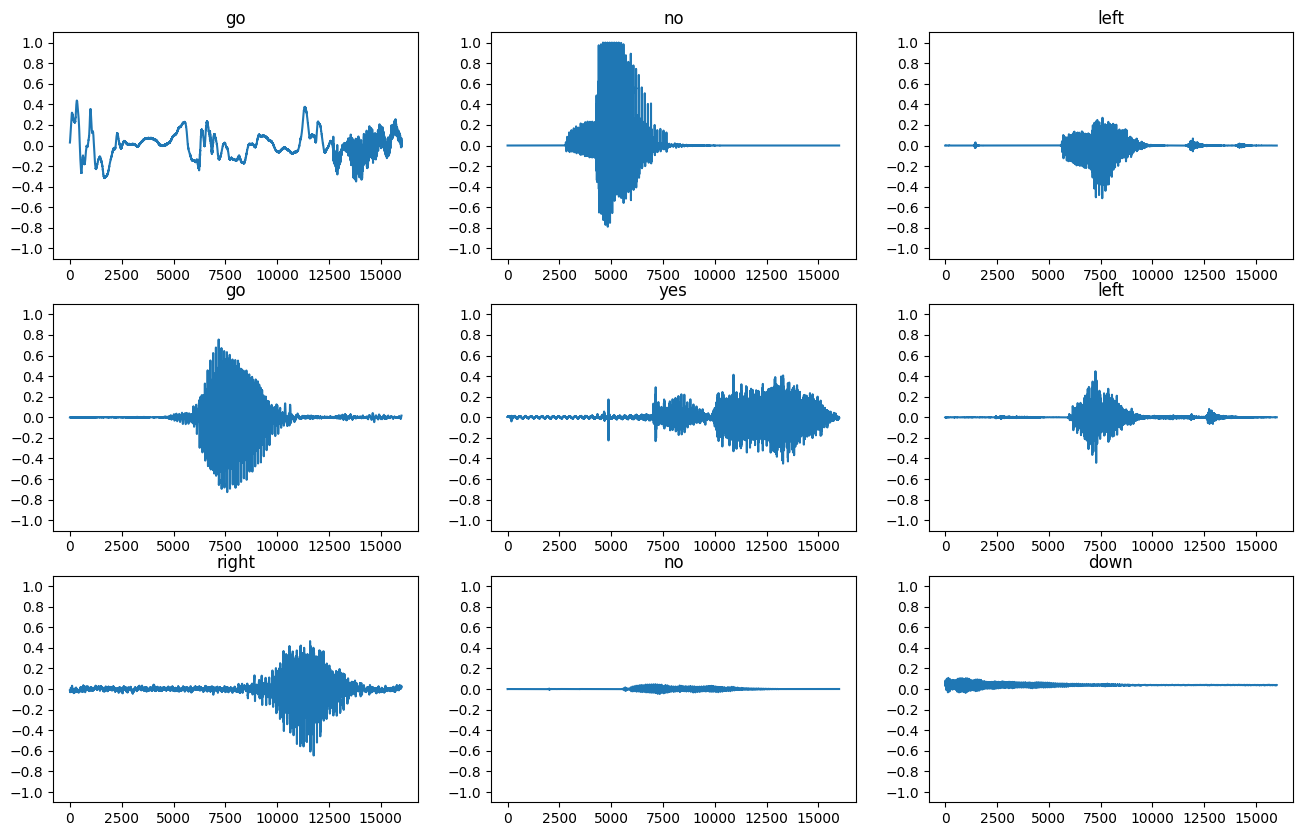

In [20]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

Convert waveforms to spectrograms
The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using tf.zeros).
When calling tf.signal.stft, choose the frame_length and frame_step parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to this Coursera video on audio signal processing and STFT.
The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying tf.abs on the output of tf.signal.stft.

In [21]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [23]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('spectrogram:', spectrogram)
  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

spectrogram: tf.Tensor(
[[[3.4235596e+01]
  [1.9337328e+01]
  [2.6899245e+00]
  ...
  [2.6822090e-05]
  [1.3949347e-04]
  [5.7220459e-06]]

 [[3.5806953e+01]
  [1.6656513e+01]
  [3.3873305e+00]
  ...
  [3.3487758e-04]
  [2.0438021e-04]
  [9.1552734e-05]]

 [[4.0943718e+01]
  [2.5156359e+01]
  [3.3272662e+00]
  ...
  [3.0768683e-04]
  [1.3104609e-04]
  [4.0054321e-05]]

 ...

 [[1.9845640e+01]
  [1.0622676e+01]
  [1.0164214e+00]
  ...
  [4.2772404e-04]
  [2.5536233e-04]
  [2.2697449e-04]]

 [[1.9537941e+01]
  [1.0519169e+01]
  [5.7039380e-01]
  ...
  [1.0526255e-04]
  [1.2436791e-04]
  [1.8119812e-05]]

 [[1.1193793e+01]
  [5.6563950e+00]
  [4.7435373e-01]
  ...
  [1.8905060e-04]
  [9.9272373e-05]
  [2.8610229e-06]]], shape=(124, 129, 1), dtype=float32)
Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


spectrogram: tf.Tensor(
[[[5.8976366e-06]
  [1.2317393e-03]
  [4.8631290e-04]
  ...
  [8.2903243e-05]
  [2.9110710e-05]
  [7.7313234e-06]]

 [[5.8641203e-04]
  [2.2095460e-03]
  [3.4916827e-03]
  ...
  [9.8714037e-05]
  [1.5966622e-04]
  [1.5415018e-05]]

 [[8.5613246e-05]
  [8.2395098e-04]
  [1.8438977e-03]
  ...
  [1.5869143e-04]
  [1.5390817e-04]
  [2.2217057e-05]]

 ...

 [[1.7690698e-03]
  [3.4630136e-03]
  [4.5365994e-03]
  ...
  [1.4754118e-04]
  [1.0001298e-04]
  [6.3111249e-05]]

 [[2.7208580e-03]
  [2.4222431e-03]
  [1.6509817e-03]
  ...
  [9.5664785e-05]
  [1.5106250e-04]
  [1.5623553e-04]]

 [[1.9630531e-03]
  [2.4222399e-03]
  [1.0117518e-03]
  ...
  [4.6710251e-05]
  [4.1203799e-05]
  [8.7223714e-05]]], shape=(124, 129, 1), dtype=float32)
Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


spectrogram: tf.Tensor(
[[[3.35706514e-04]
  [1.15638413e-03]
  [3.73597280e-03]
  ...
  [1.62941695e-04]
  [1.32544694e-04]
  [5.46905212e-05]]

 [[7.51128187e-04]
  [1.65893766e-03]
  [7.15297507e-03]
  ...
  [4.22617741e-05]
  [8.73810277e-05]
  [5.77185710e-05]]

 [[6.49271533e-06]
  [3.07534076e-03]
  [1.09193316e-02]
  ...
  [3.86440479e-05]
  [5.80851738e-05]
  [8.85164482e-05]]

 ...

 [[1.03301456e-04]
  [1.73486071e-04]
  [9.20422957e-04]
  ...
  [5.41400841e-05]
  [3.44755317e-05]
  [5.02240437e-05]]

 [[4.16471885e-05]
  [8.52890604e-04]
  [3.05024092e-03]
  ...
  [4.74011504e-05]
  [3.74582269e-05]
  [4.84344055e-05]]

 [[1.14844544e-04]
  [1.16415066e-03]
  [4.95310733e-03]
  ...
  [5.87260547e-05]
  [3.66485110e-05]
  [5.72941644e-05]]], shape=(124, 129, 1), dtype=float32)
Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


spectrogram: a 2D or 3D NumPy array representing the spectrogram data.
ax: a matplotlib Axes object where the spectrogram will be plotted.

It asserts that the number of dimensions is exactly 3.
It removes the last dimension using np.squeeze, effectively converting the 3D array to 2D.

Transposes the spectrogram array so that time is represented on the x-axis.
Adds a small value (np.finfo(float).eps) to avoid taking the logarithm of zero.
Applies natural logarithm scaling to the spectrogram values.

X: an array of evenly spaced values representing the x-axis (time).
Y: an array of integers representing the y-axis (frequency).

X and Y are used as the x and y coordinates.
log_spec is used as the color values.

In [24]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

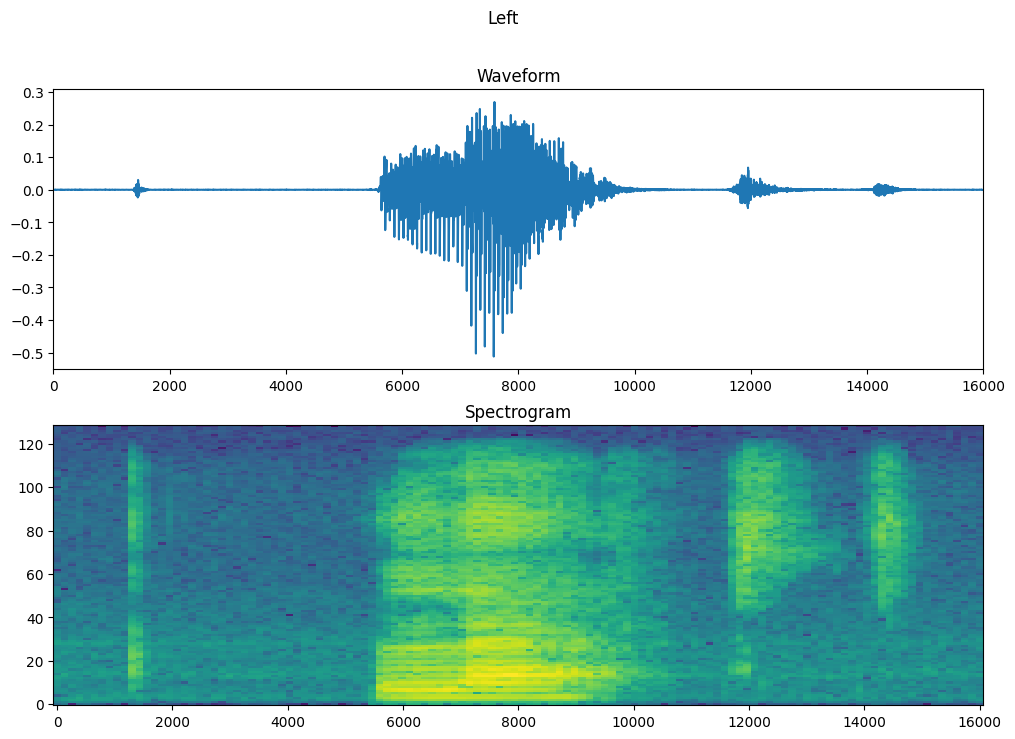

In [25]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

create spectrogram datasets from the audio datasets

In [26]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [27]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [28]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

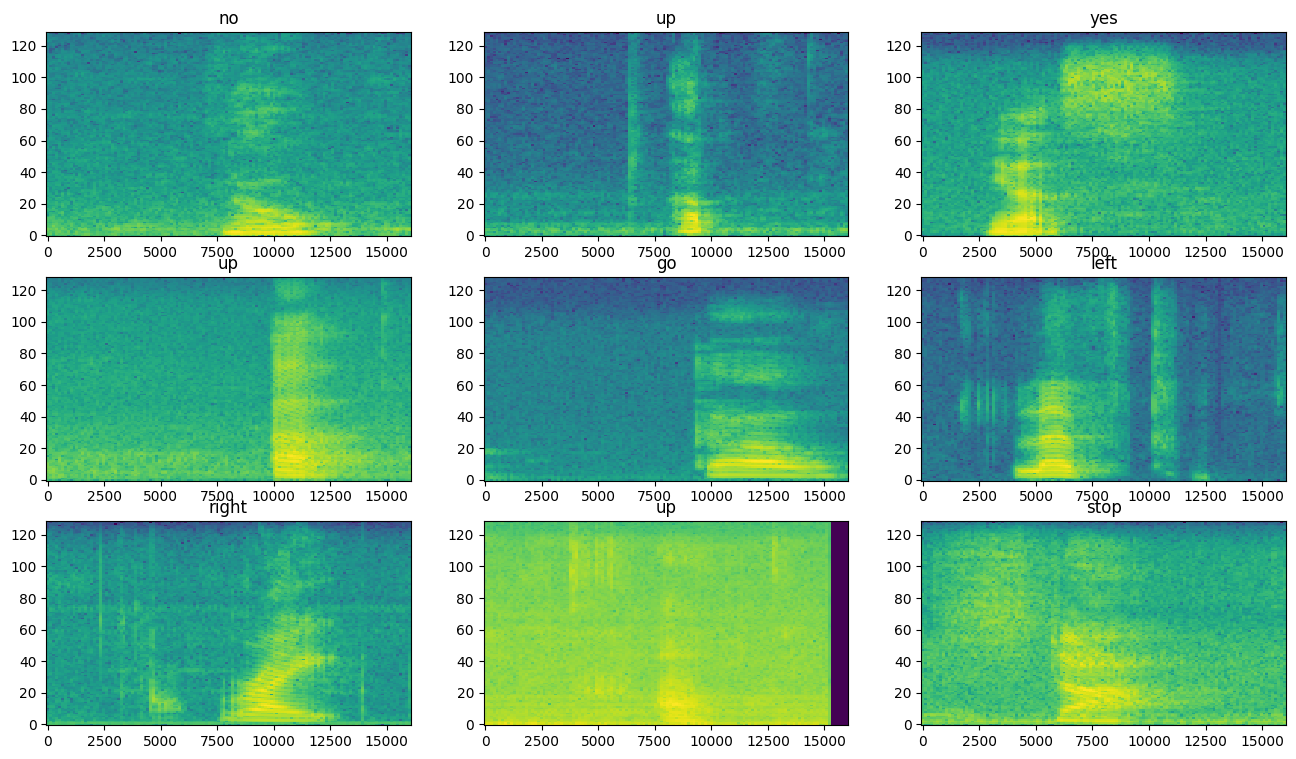

In [29]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Build and train the model
Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:

In [30]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your tf.keras.Sequential model will use the following Keras preprocessing layers:

tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.
For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation

In [32]:
example_spectrograms.shape

TensorShape([64, 124, 129, 1])

In [31]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)


Input shape: (124, 129, 1)


In [33]:
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

In [34]:


model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [36]:
EPOCHS = 3
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.2981 - loss: 1.9182 - val_accuracy: 0.6393 - val_loss: 1.2665
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5739 - loss: 1.2394 - val_accuracy: 0.7031 - val_loss: 0.9135
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6880 - loss: 0.9134 - val_accuracy: 0.7747 - val_loss: 0.7311


Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

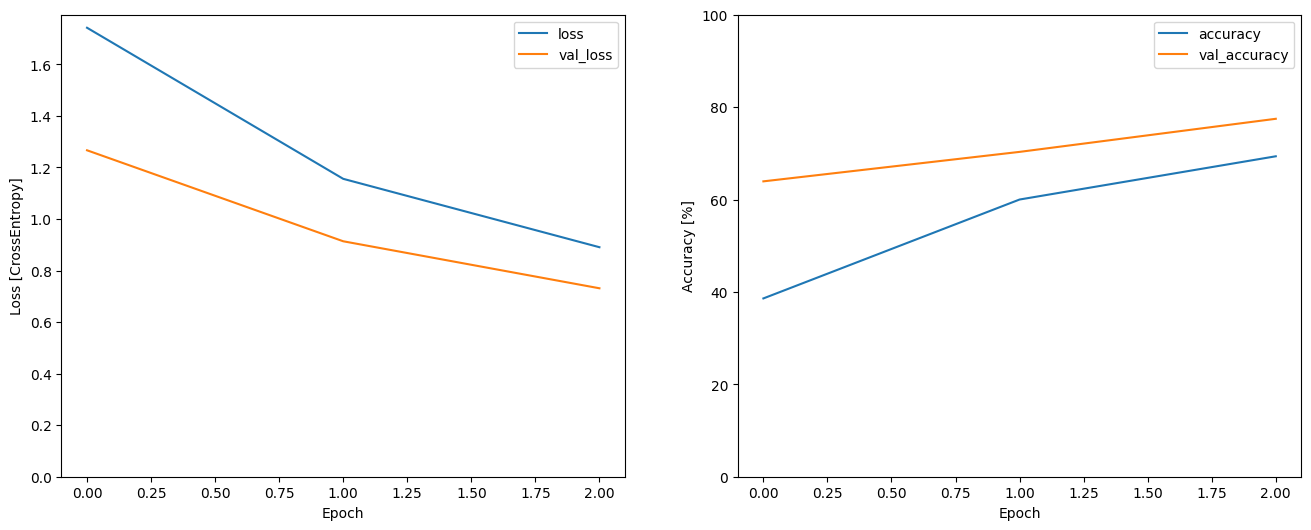

In [37]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Evaluate the model performance
Run the model on the test set and check the model's performance

In [38]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7141 - loss: 0.7988


{'accuracy': 0.7319711446762085, 'loss': 0.7688261866569519}

Display a confusion matrix
Use a confusion matrix to check how well the model did classifying each of the commands in the test set:



In [39]:
y_pred = model.predict(test_spectrogram_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [40]:
y_pred = tf.argmax(y_pred, axis=1)

In [42]:
y_pred

<tf.Tensor: shape=(832,), dtype=int64, numpy=
array([6, 7, 7, 6, 0, 5, 1, 0, 1, 2, 1, 1, 3, 6, 4, 0, 4, 2, 4, 4, 0, 5,
       4, 3, 3, 6, 2, 2, 7, 4, 1, 4, 1, 1, 4, 7, 6, 4, 3, 6, 4, 7, 1, 6,
       0, 1, 2, 1, 3, 3, 4, 1, 7, 5, 1, 1, 5, 3, 2, 7, 3, 4, 0, 0, 5, 1,
       3, 4, 7, 3, 5, 7, 6, 1, 4, 5, 7, 2, 5, 4, 7, 6, 0, 6, 4, 4, 6, 1,
       5, 5, 5, 1, 7, 3, 5, 3, 3, 4, 7, 1, 5, 0, 1, 7, 4, 6, 7, 3, 6, 3,
       6, 5, 7, 1, 6, 6, 2, 6, 5, 4, 6, 6, 3, 7, 6, 4, 3, 4, 3, 4, 4, 5,
       0, 1, 0, 5, 1, 2, 1, 5, 3, 7, 7, 5, 5, 2, 7, 7, 0, 7, 0, 5, 0, 5,
       5, 7, 7, 0, 2, 2, 3, 1, 1, 7, 2, 6, 5, 3, 6, 6, 7, 0, 5, 1, 7, 6,
       4, 0, 3, 3, 3, 7, 1, 0, 2, 7, 0, 1, 2, 7, 6, 6, 7, 6, 5, 6, 5, 1,
       2, 6, 7, 2, 7, 4, 3, 1, 6, 1, 4, 4, 1, 7, 3, 7, 5, 5, 1, 7, 1, 2,
       2, 0, 1, 0, 3, 3, 5, 5, 4, 1, 6, 5, 6, 3, 6, 6, 0, 1, 1, 7, 4, 7,
       3, 2, 6, 7, 5, 7, 7, 3, 4, 3, 2, 4, 3, 7, 1, 1, 4, 6, 7, 7, 5, 4,
       4, 2, 3, 2, 7, 2, 0, 7, 2, 4, 4, 2, 4, 7, 1, 1, 4, 0, 0, 6, 0, 4,
     

In [41]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [43]:
y_true

<tf.Tensor: shape=(832,), dtype=int32, numpy=
array([6, 7, 6, 6, 0, 5, 7, 0, 2, 2, 1, 5, 3, 1, 4, 0, 4, 2, 2, 4, 1, 5,
       4, 3, 3, 3, 2, 2, 7, 4, 3, 4, 1, 3, 4, 7, 1, 4, 1, 5, 2, 2, 1, 6,
       3, 3, 2, 0, 3, 1, 4, 1, 2, 5, 1, 3, 5, 3, 2, 7, 1, 4, 3, 0, 5, 1,
       3, 4, 7, 3, 5, 7, 5, 1, 4, 5, 7, 2, 5, 4, 3, 6, 0, 6, 2, 3, 2, 1,
       5, 5, 5, 1, 7, 1, 2, 1, 3, 4, 7, 1, 5, 0, 3, 7, 4, 2, 7, 3, 6, 1,
       6, 5, 2, 3, 6, 6, 2, 0, 5, 4, 6, 6, 3, 7, 6, 2, 3, 4, 0, 2, 4, 5,
       0, 1, 1, 5, 1, 7, 3, 6, 3, 7, 7, 5, 5, 2, 7, 7, 0, 0, 0, 5, 0, 5,
       1, 7, 7, 1, 2, 2, 0, 1, 3, 2, 2, 3, 0, 3, 6, 5, 7, 0, 5, 1, 7, 6,
       4, 0, 2, 1, 3, 7, 3, 0, 2, 7, 0, 3, 4, 7, 6, 6, 7, 5, 5, 5, 5, 6,
       2, 6, 4, 2, 7, 4, 3, 0, 6, 3, 4, 4, 1, 7, 5, 7, 5, 5, 1, 7, 1, 2,
       2, 0, 1, 3, 3, 3, 1, 3, 4, 1, 6, 5, 6, 3, 6, 6, 0, 3, 0, 7, 4, 7,
       3, 2, 6, 7, 5, 7, 7, 1, 4, 4, 2, 4, 3, 7, 1, 3, 4, 6, 7, 7, 5, 4,
       7, 6, 1, 2, 7, 2, 0, 7, 5, 6, 6, 0, 4, 7, 1, 1, 2, 1, 0, 6, 0, 2,
     

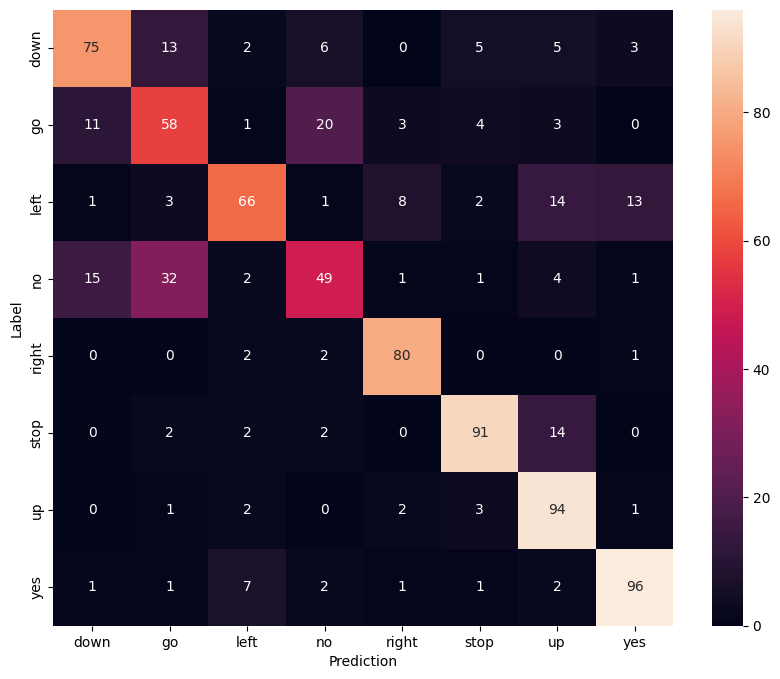

In [44]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Run inference on an audio file
Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

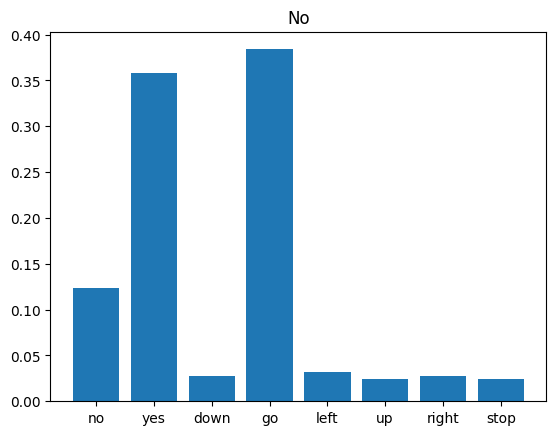

In [ ]:
x = 'mini_speech_commands_extracted'/data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))  # predict go
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

Export the model with preprocessing
The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version

The line of code x = x[tf.newaxis, :] adds a new dimension to the tensor x at the beginning (index 0).
Explanation
tf.newaxis is equivalent to None and is used to indicate a new axis.
: means "take all elements" in the existing dimensions.

In [1]:
# import tensorflow as tf

# x = tf.constant([1, 2, 3])
# print("Original shape:", x.shape)  # Output: (3,)

# x = x[tf.newaxis, :]
# print("New shape:", x.shape)  # Output: (1, 3)

Expanding dimensions for broadcasting: Adding a new dimension to enable broadcasting in tensor operations.
Model input preparation: Converting data into the expected input shape for a deep learning model.
Data augmentation: Adding a dimension for stacking augmented data samples.
Best Practices
Use tf.expand_dims(x, 0) instead for better readability.
Avoid using tf.newaxis multiple times; instead, use tf.expand_dims repeatedly or x[None, :, None, :] for clarity.

In [48]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [50]:
export = ExportModel(model)
export(tf.constant(str('mini_speech_commands_extracted'/data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.53346527,  1.6027921 , -0.97045183,  1.6715711 , -0.83017784,
         -1.0866534 , -0.96232355, -1.106124  ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [51]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.53346527,  1.6027921 , -0.97045183,  1.6715711 , -0.83017784,
         -1.0866534 , -0.96232355, -1.106124  ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}